## Source

- Energy consumption data obtained from Appendix I: Detailed Energy Balance from page 52 of the 2023 MEMD Statistical Abstract

In [22]:
import numpy as np
import pandas as pd
import os
from utils.utils import *

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
edau = EDAUtils()
gu = GeneralUtils()

In [25]:
# Set up paths
CURRENT_DIR_PATH = os.getcwd()
OUTPUT_DATA_DIR_PATH = os.path.join(CURRENT_DIR_PATH, "output_data")
INPUT_DATA_DIR_PATH = os.path.join(CURRENT_DIR_PATH, "input_data")

In [26]:
# Set scoe type
scoe_type = "residential"

In [27]:
# load final energy consumption by fuel data
consump_by_fuel_df = pd.read_csv(os.path.join(INPUT_DATA_DIR_PATH, "inen","final_energy_consumption_by_fuel_uganda_2023.csv"))
consump_by_fuel_df.head()

,Sector,LPG,Gasoline,Jet Kerosene,Other Kerosene,Gas/Diesel Oil,Fuel oil,Wood fuel,Bagasse,Rice husks,Other vegetal waste,Animal waste,Biomass briquettes,Charcoal,Biogas,Hydro,Solar PV,Electricity,Total
0,Iron and steel,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,193,193
1,Chemical (including petrochemical),0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,32
2,Non-metallic minerals,0,0,0,0,0,0,545,0,0,0,0,0,0,0,0,0,0,545
3,Machinery,0,97,0,0,297,0,0,0,0,0,0,0,0,0,0,0,0,394
4,"Food, beverages and tobacco",0,0,0,0,0,0,293,0,0,0,0,0,392,0,0,0,52,737


In [28]:
# Aggregate some fields
consump_by_fuel_df["Kerosene"] = consump_by_fuel_df["Jet Kerosene"] + consump_by_fuel_df["Other Kerosene"]
consump_by_fuel_df["Solid biomass"] = consump_by_fuel_df["Wood fuel"] + consump_by_fuel_df["Bagasse"] + consump_by_fuel_df["Rice husks"] + consump_by_fuel_df["Other vegetal waste"] +  consump_by_fuel_df["Animal waste"] + consump_by_fuel_df["Biomass briquettes"] + consump_by_fuel_df["Charcoal"]
consump_by_fuel_df["Electricity_and_hydro"] = consump_by_fuel_df["Electricity"] + consump_by_fuel_df["Hydro"]
consump_by_fuel_df["Diesel"] = consump_by_fuel_df["Gas/Diesel Oil"] * 0.90
consump_by_fuel_df["Furnace gas"] = consump_by_fuel_df["Gas/Diesel Oil"] * 0.10
consump_by_fuel_df["Natural gas"] = consump_by_fuel_df["Gas/Diesel Oil"] * 0.00
consump_by_fuel_df.head()

,Sector,LPG,Gasoline,Jet Kerosene,Other Kerosene,Gas/Diesel Oil,Fuel oil,Wood fuel,Bagasse,Rice husks,...,Hydro,Solar PV,Electricity,Total,Kerosene,Solid biomass,Electricity_and_hydro,Diesel,Furnace gas,Natural gas
0,Iron and steel,0,0,0,0,0,0,0,0,0,...,0,0,193,193,0,0,193,0.0,0.0,0.0
1,Chemical (including petrochemical),0,0,0,32,0,0,0,0,0,...,0,0,0,32,32,0,0,0.0,0.0,0.0
2,Non-metallic minerals,0,0,0,0,0,0,545,0,0,...,0,0,0,545,0,545,0,0.0,0.0,0.0
3,Machinery,0,97,0,0,297,0,0,0,0,...,0,0,0,394,0,0,0,267.3,29.7,0.0
4,"Food, beverages and tobacco",0,0,0,0,0,0,293,0,0,...,0,0,52,737,0,685,52,0.0,0.0,0.0


In [29]:
consump_by_fuel_df["Sector"]

0                            Iron and steel
1        Chemical (including petrochemical)
2                     Non-metallic minerals
3                                 Machinery
4               Food, beverages and tobacco
5                                      Road
6                                      Rail
7                       Domestic navigation
8                         Domestic aviation
9                                Households
10           Commercial and Public Services
11        Agriculture, Forestry and Fishing
12    Non-specified (HH, Com. & PS., Agri.)
13                           Non-energy use
14                         Industry - Total
15                        Transport - Total
16                        Final consumption
Name: Sector, dtype: object

In [30]:
sector_type = "Households"
base_year = 2023

In [31]:
# Filter consumption data for the specific sector
consump_by_fuel_df_filtered = consump_by_fuel_df[consump_by_fuel_df["Sector"] == sector_type]
consump_by_fuel_df_filtered

,Sector,LPG,Gasoline,Jet Kerosene,Other Kerosene,Gas/Diesel Oil,Fuel oil,Wood fuel,Bagasse,Rice husks,...,Hydro,Solar PV,Electricity,Total,Kerosene,Solid biomass,Electricity_and_hydro,Diesel,Furnace gas,Natural gas
9,Households,25,0,0,8,0,0,4608,0,211,...,0,0,84,8031,8,7861,84,0.0,0.0,0.0


In [32]:
fuel_mapping = {
    f'frac_scoe_heat_energy_{scoe_type}_coal': 0, 
    # f'frac_scoe_heat_energy_{scoe_type}_coke': 0,
    f'frac_scoe_heat_energy_{scoe_type}_diesel': consump_by_fuel_df_filtered["Diesel"].values[0],
    f'frac_scoe_heat_energy_{scoe_type}_hydrogen': 0,
    f'frac_scoe_heat_energy_{scoe_type}_gasoline': consump_by_fuel_df_filtered["Gasoline"].values[0],
    f'frac_scoe_heat_energy_{scoe_type}_hydrocarbon_gas_liquids': consump_by_fuel_df_filtered["LPG"].values[0],
    f'frac_scoe_heat_energy_{scoe_type}_solid_biomass': consump_by_fuel_df_filtered["Solid biomass"].values[0],
    # f'frac_scoe_heat_energy_{scoe_type}_oil': consump_by_fuel_df_filtered["Fuel oil"].values[0],
    f'frac_scoe_heat_energy_{scoe_type}_natural_gas': consump_by_fuel_df_filtered["Natural gas"].values[0],
    # f'frac_scoe_heat_energy_{scoe_type}_furnace_gas': consump_by_fuel_df_filtered["Furnace gas"].values[0],
    f'frac_scoe_heat_energy_{scoe_type}_kerosene': consump_by_fuel_df_filtered["Kerosene"].values[0],
    f'frac_scoe_heat_energy_{scoe_type}_electricity': consump_by_fuel_df_filtered["Electricity_and_hydro"].values[0],
    # f'frac_scoe_heat_energy_{scoe_type}_solar': consump_by_fuel_df_filtered["Solar PV"].values[0],
}

fuel_mapping


{'frac_scoe_heat_energy_residential_coal': 0,
 'frac_scoe_heat_energy_residential_diesel': np.float64(0.0),
 'frac_scoe_heat_energy_residential_hydrogen': 0,
 'frac_scoe_heat_energy_residential_gasoline': np.int64(0),
 'frac_scoe_heat_energy_residential_hydrocarbon_gas_liquids': np.int64(25),
 'frac_scoe_heat_energy_residential_solid_biomass': np.int64(7861),
 'frac_scoe_heat_energy_residential_natural_gas': np.float64(0.0),
 'frac_scoe_heat_energy_residential_kerosene': np.int64(8),
 'frac_scoe_heat_energy_residential_electricity': np.int64(84)}

In [33]:
# Create df from the mapping
frac_scoe_heat_energy_df = pd.DataFrame(fuel_mapping, index=[0])
frac_scoe_heat_energy_df

,frac_scoe_heat_energy_residential_coal,frac_scoe_heat_energy_residential_diesel,frac_scoe_heat_energy_residential_hydrogen,frac_scoe_heat_energy_residential_gasoline,frac_scoe_heat_energy_residential_hydrocarbon_gas_liquids,frac_scoe_heat_energy_residential_solid_biomass,frac_scoe_heat_energy_residential_natural_gas,frac_scoe_heat_energy_residential_kerosene,frac_scoe_heat_energy_residential_electricity
0,0,0.0,0,0,25,7861,0.0,8,84


In [34]:
# normalize the df
frac_scoe_heat_energy_df = frac_scoe_heat_energy_df.div(frac_scoe_heat_energy_df.sum(axis=1), axis=0)
frac_scoe_heat_energy_df

,frac_scoe_heat_energy_residential_coal,frac_scoe_heat_energy_residential_diesel,frac_scoe_heat_energy_residential_hydrogen,frac_scoe_heat_energy_residential_gasoline,frac_scoe_heat_energy_residential_hydrocarbon_gas_liquids,frac_scoe_heat_energy_residential_solid_biomass,frac_scoe_heat_energy_residential_natural_gas,frac_scoe_heat_energy_residential_kerosene,frac_scoe_heat_energy_residential_electricity
0,0.0,0.0,0.0,0.0,0.003134,0.985335,0.0,0.001003,0.010529


In [35]:
# Add the base year to the df
frac_scoe_heat_energy_df["year"] = base_year

# Set the year field to be at the beginning of the df
frac_scoe_heat_energy_df = frac_scoe_heat_energy_df[["year"] + [col for col in frac_scoe_heat_energy_df.columns if col != "year"]]
frac_scoe_heat_energy_df

,year,frac_scoe_heat_energy_residential_coal,frac_scoe_heat_energy_residential_diesel,frac_scoe_heat_energy_residential_hydrogen,frac_scoe_heat_energy_residential_gasoline,frac_scoe_heat_energy_residential_hydrocarbon_gas_liquids,frac_scoe_heat_energy_residential_solid_biomass,frac_scoe_heat_energy_residential_natural_gas,frac_scoe_heat_energy_residential_kerosene,frac_scoe_heat_energy_residential_electricity
0,2023,0.0,0.0,0.0,0.0,0.003134,0.985335,0.0,0.001003,0.010529


In [36]:
# project backward
frac_scoe_heat_energy_df = gu.extend_years_backward(frac_scoe_heat_energy_df, "year", 2023, np.arange(2015, 2023).tolist())
frac_scoe_heat_energy_df

,year,frac_scoe_heat_energy_residential_coal,frac_scoe_heat_energy_residential_diesel,frac_scoe_heat_energy_residential_hydrogen,frac_scoe_heat_energy_residential_gasoline,frac_scoe_heat_energy_residential_hydrocarbon_gas_liquids,frac_scoe_heat_energy_residential_solid_biomass,frac_scoe_heat_energy_residential_natural_gas,frac_scoe_heat_energy_residential_kerosene,frac_scoe_heat_energy_residential_electricity
0,2015,0.0,0.0,0.0,0.0,0.003134,0.985335,0.0,0.001003,0.010529
1,2016,0.0,0.0,0.0,0.0,0.003134,0.985335,0.0,0.001003,0.010529
2,2017,0.0,0.0,0.0,0.0,0.003134,0.985335,0.0,0.001003,0.010529
3,2018,0.0,0.0,0.0,0.0,0.003134,0.985335,0.0,0.001003,0.010529
4,2019,0.0,0.0,0.0,0.0,0.003134,0.985335,0.0,0.001003,0.010529
5,2020,0.0,0.0,0.0,0.0,0.003134,0.985335,0.0,0.001003,0.010529
6,2021,0.0,0.0,0.0,0.0,0.003134,0.985335,0.0,0.001003,0.010529
7,2022,0.0,0.0,0.0,0.0,0.003134,0.985335,0.0,0.001003,0.010529
8,2023,0.0,0.0,0.0,0.0,0.003134,0.985335,0.0,0.001003,0.010529


In [37]:
# project forward
frac_scoe_heat_energy_df_extended = gu.extend_projection(frac_scoe_heat_energy_df, base_year + 1, 2100)
frac_scoe_heat_energy_df_extended

,year,frac_scoe_heat_energy_residential_coal,frac_scoe_heat_energy_residential_diesel,frac_scoe_heat_energy_residential_hydrogen,frac_scoe_heat_energy_residential_gasoline,frac_scoe_heat_energy_residential_hydrocarbon_gas_liquids,frac_scoe_heat_energy_residential_solid_biomass,frac_scoe_heat_energy_residential_natural_gas,frac_scoe_heat_energy_residential_kerosene,frac_scoe_heat_energy_residential_electricity
0,2015,0.0,0.0,0.0,0.0,0.003134,0.985335,0.0,0.001003,0.010529
1,2016,0.0,0.0,0.0,0.0,0.003134,0.985335,0.0,0.001003,0.010529
2,2017,0.0,0.0,0.0,0.0,0.003134,0.985335,0.0,0.001003,0.010529
3,2018,0.0,0.0,0.0,0.0,0.003134,0.985335,0.0,0.001003,0.010529
4,2019,0.0,0.0,0.0,0.0,0.003134,0.985335,0.0,0.001003,0.010529
...,...,...,...,...,...,...,...,...,...,...
81,2096,0.0,0.0,0.0,0.0,0.003134,0.985335,0.0,0.001003,0.010529
82,2097,0.0,0.0,0.0,0.0,0.003134,0.985335,0.0,0.001003,0.010529
83,2098,0.0,0.0,0.0,0.0,0.003134,0.985335,0.0,0.001003,0.010529
84,2099,0.0,0.0,0.0,0.0,0.003134,0.985335,0.0,0.001003,0.010529


## Validation

In [38]:
# check for duplicates
gu.check_duplicates(frac_scoe_heat_energy_df_extended)

No duplicated years found in the DataFrame.
No duplicated rows found in the DataFrame.


In [39]:
# load global data
uga_global_df = pd.read_csv(os.path.join(INPUT_DATA_DIR_PATH, "sisepuede_raw_global_inputs_uganda.csv"))
uga_global_df.head()

,frac_agrc_nuts_cl1_temperate,yf_agrc_cereals_tonne_ha,frac_agrc_rice_cl2_wet,frac_agrc_cereals_cl1_tropical,frac_agrc_tubers_cl1_tropical,pop_lvst_initial_chickens,frac_agrc_bevs_and_spices_cl2_wet,frac_agrc_tubers_cl2_wet,frac_frst_primary_cl1_temperate_nutrient_rich,frac_lndu_grasslands_cl2_dry,...,nemomod_entc_frac_min_share_production_pp_biogas,nemomod_entc_frac_min_share_production_pp_coal,nemomod_entc_frac_min_share_production_pp_coal_ccs,nemomod_entc_frac_min_share_production_pp_gas,nemomod_entc_frac_min_share_production_pp_gas_ccs,nemomod_entc_frac_min_share_production_pp_geothermal,nemomod_entc_frac_min_share_production_pp_nuclear,nemomod_entc_frac_min_share_production_pp_ocean,nemomod_entc_frac_min_share_production_pp_waste_incineration,nemomod_entc_frac_min_share_production_pp_wind
0,0.030468,1.805033,0.988021,0.969532,0.969532,46039000,0.988021,0.988021,0.015234,0.011979,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.030468,1.832342,0.988021,0.969532,0.969532,46291000,0.988021,0.988021,0.015234,0.011979,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.030468,1.827437,0.988021,0.969532,0.969532,47578000,0.988021,0.988021,0.015234,0.011979,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.030468,1.935353,0.988021,0.969532,0.969532,48901000,0.988021,0.988021,0.015234,0.011979,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.030468,2.003586,0.988021,0.969532,0.969532,43121000,0.988021,0.988021,0.015234,0.011979,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
print(gu.check_row_sums_to_one(frac_scoe_heat_energy_df_extended))

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True]), np.True_)


Comparing frac_scoe_heat_energy_residential_coal...


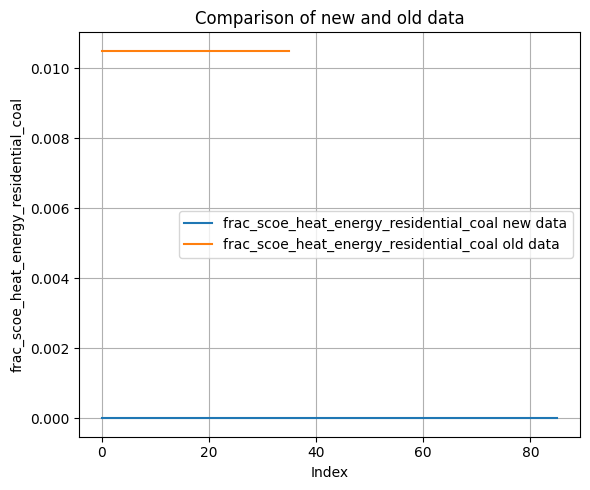

Comparing frac_scoe_heat_energy_residential_diesel...


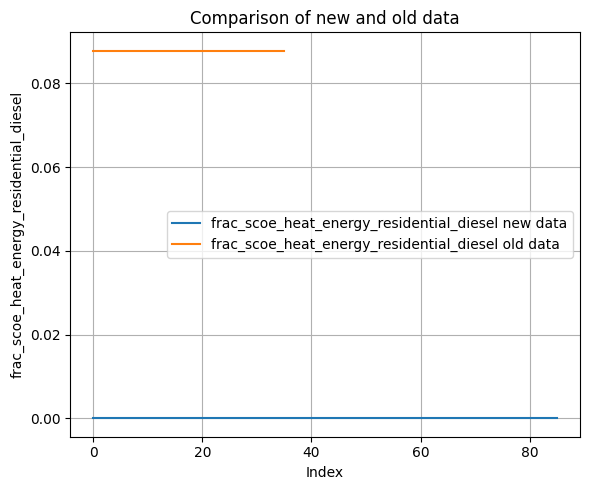

Comparing frac_scoe_heat_energy_residential_hydrogen...


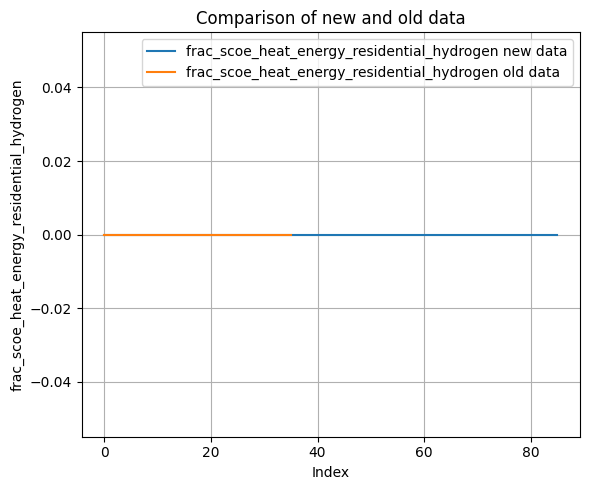

Comparing frac_scoe_heat_energy_residential_gasoline...


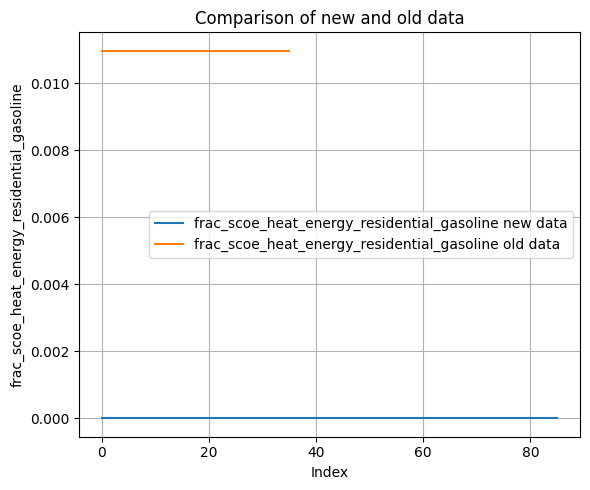

Comparing frac_scoe_heat_energy_residential_hydrocarbon_gas_liquids...


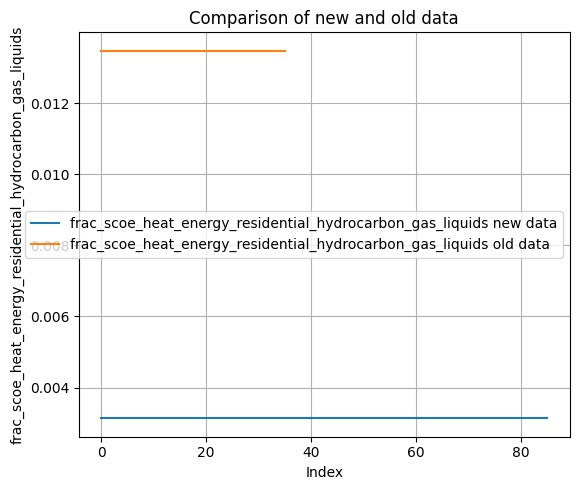

Comparing frac_scoe_heat_energy_residential_solid_biomass...


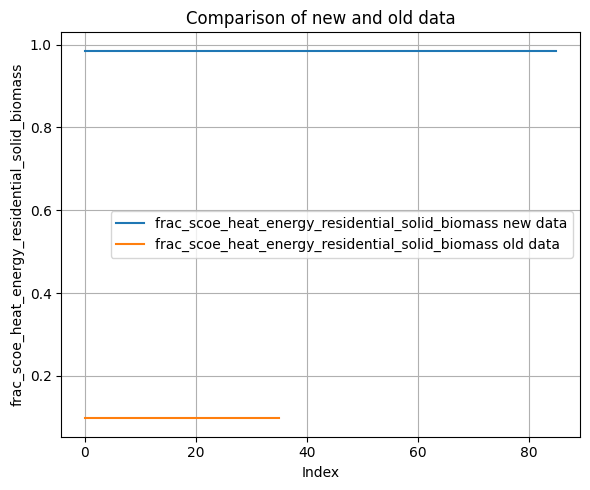

Comparing frac_scoe_heat_energy_residential_natural_gas...


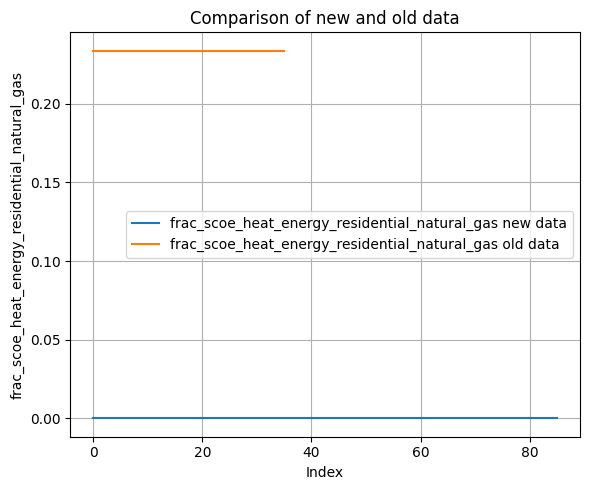

Comparing frac_scoe_heat_energy_residential_kerosene...


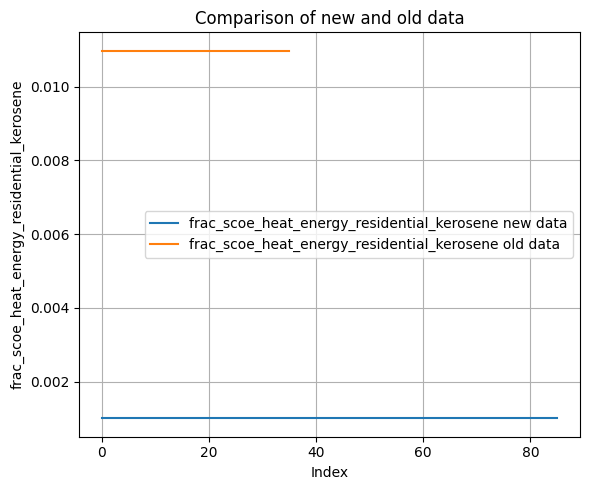

Comparing frac_scoe_heat_energy_residential_electricity...


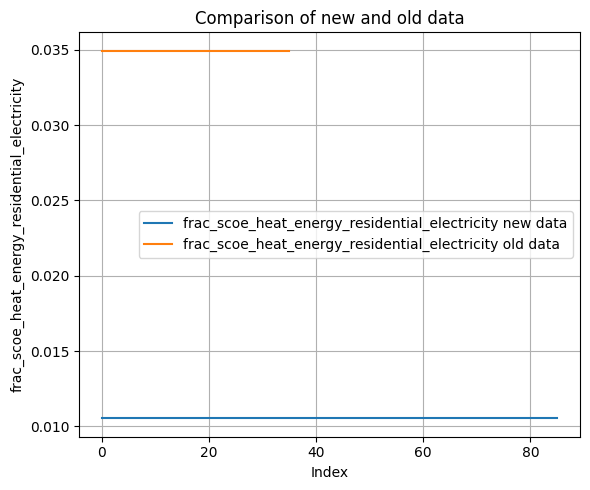

In [41]:
for var in frac_scoe_heat_energy_df_extended.columns:
    if var != 'year':
        print(f"Comparing {var}...")
        edau.compare_variables(frac_scoe_heat_energy_df_extended, uga_global_df, [var])

In [43]:
frac_scoe_heat_energy_df_extended.to_csv(os.path.join(OUTPUT_DATA_DIR_PATH, f"frac_scoe_heat_energy_{scoe_type}.csv"), index=False)